# Gradient (AD), ML and Bankruptcy prediction

***Import packages and definition of usefull functions***

In [1]:
import math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

## 1. Definition of the Bankrupty prediction use case and data management

**Altman
's Z-score**

Altman (1968) came up with a simple formula known as Z-score, whose expression is:
\begin{equation*}
    Z = 0.12 X_1 + 0.14 X_2 + 0.033 X_3 + 0.006 X_4 + 0.999 X_5
\end{equation*}
where
- $X_1$ is the working capital / total assets
- $X_2$ is the retained earnings / total assets
- $X_3$ is the earnings before interest and tax / total assets
- $X_4$ i sthe market value of equity / total liabilities
- $X_5$ is sale / total assets
Based on the value of the score a firm is classified as bankrupt (low score) or healthy (high score).

Bankruptcy refers to a situation where firm cannot repay its debts to its creditors.

As bankruptcy is costly for company stakeholders (employees, supppliers, banks), being able to predict its likelihood is of critical importance.

Particularly important nowadays with the rise of the so-called *zombie companies*.

### 1.1 Import Data

We use [the Polish companies bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data).

5 datasets:
- For companies in file ``1year``, the reported status is the one observed 5 years later.
 - For companies in file ``2year``, the reported status is the one observed 4 years later.
- ...
- For companies in file ``5year``, the reported status is the one observed 1 year later.
    
Potentially, we could use the 5 datasets and analyze:
- whether a firm goes bankrupt or not after some time, irrespective of the number of years.
- whether a firm goes bankrupt or not after 1, 2, ..., 5 years. This would be a multiclass classification exercice.
    
For simplicity, we will focus on a binary classification problem. Working with a single file will also make the computation faster.

**Features description of the ``2year``**, there is no header but 64 features (expressed in ratios or in local currency):

- X1 net profit / total assets
- X2 total liabilities / total assets
- X3 working capital / total assets
- X4 current assets / short-term liabilities
- X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- X6 retained earnings / total assets
- X7 EBIT / total assets
- X8 book value of equity / total liabilities
- X9 sales / total assets
- X10 equity / total assets
- X11 (gross profit + extraordinary items + financial expenses) / total assets
- X12 gross profit / short-term liabilities
- X13 (gross profit + depreciation) / sales
- X14 (gross profit + interest) / total assets
- X15 (total liabilities * 365) / (gross profit + depreciation)
- X16 (gross profit + depreciation) / total liabilities
- X17 total assets / total liabilities
- X18 gross profit / total assets
- X19 gross profit / sales
- X20 (inventory * 365) / sales
- X21 sales (n) / sales (n-1)
- X22 profit on operating activities / total assets
- X23 net profit / sales
- X24 gross profit (in 3 years) / total assets
- X25 (equity - share capital) / total assets
- X26 (net profit + depreciation) / total liabilities
- X27 profit on operating activities / financial expenses
- X28 working capital / fixed assets
- X29 logarithm of total assets
- X30 (total liabilities - cash) / sales
- X31 (gross profit + interest) / sales
- X32 (current liabilities * 365) / cost of products sold
- X33 operating expenses / short-term liabilities
- X34 operating expenses / total liabilities
- X35 profit on sales / total assets
- X36 total sales / total assets
- X37 (current assets - inventories) / long-term liabilities
- X38 constant capital / total assets
- X39 profit on sales / sales
- X40 (current assets - inventory - receivables) / short-term liabilities
- X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
- X42 profit on operating activities / sales
- X43 rotation receivables + inventory turnover in days
- X44 (receivables * 365) / sales
- X45 net profit / inventory
- X46 (current assets - inventory) / short-term liabilities
- X47 (inventory * 365) / cost of products sold
- X48 EBITDA (profit on operating activities - depreciation) / total assets
- X49 EBITDA (profit on operating activities - depreciation) / sales
- X50 current assets / total liabilities
- X51 short-term liabilities / total assets
- X52 (short-term liabilities * 365) / cost of products sold)
- X53 equity / fixed assets
- X54 constant capital / fixed assets
- X55 working capital
- X56 (sales - cost of products sold) / sales
- X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- X58 total costs /total sales
- X59 long-term liabilities / equity
- X60 sales / inventory
- X61 sales / receivables
- X62 (short-term liabilities *365) / sales
- X63 sales / short-term liabilities
- X64 sales / fixed assets

Finally, the dataset reports for each instance, in the last column, a label taht take on the values 0 and 1:

- Feature 65 : 0/1 = survived/went bankrupt in the next year

**Our objective is to build a model taht identifies as accurately as possible the true label. This is a supervised learning taxt as the label of each company is reported in the datasets.**

**Task 1**: import data

In [2]:
df = pd.read_csv("year2.txt", header=None, na_values=["?"])
print(df.shape)
df.head()

(10173, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


### 1.2 Missing data

Missing values are reported using ? character.

**Task 2**: Generate a barplot that displays for each feature the number of missing values

<AxesSubplot:>

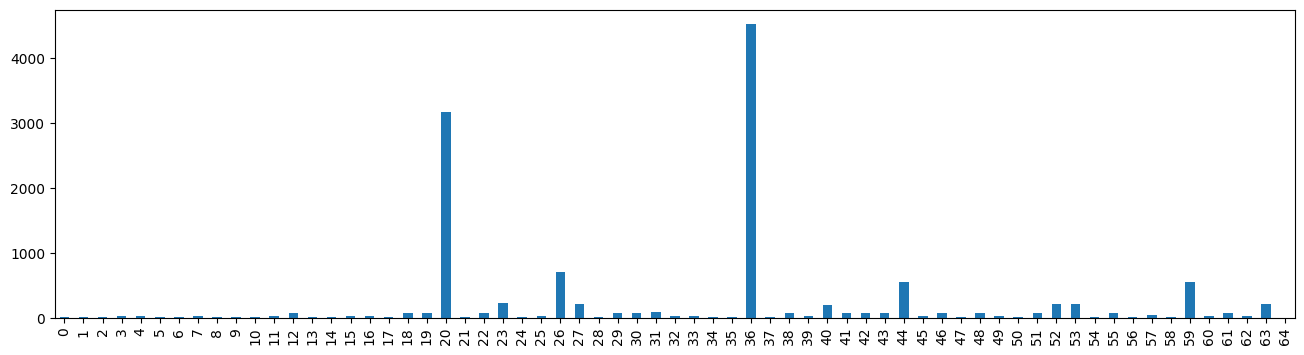

In [3]:
# insert your code here
plt.figure(figsize=(16,4))
(len(df.index)-df.count()).plot.bar()

A possible solution to handle missing values is to inpute a replacement value (e.g. mean or median of the feature)

Here, we use a simpler solution: we remove all features that contains more than 50 missing values. Once this is done, we remove all instance that still contains missing values.

**Task 3**:
- Step 1: Remove from the dataset all features that contain more than 50 missing values
- Step 2: Remove all missing values from the dataset

In [4]:
# insert your code here
df = df.drop(df.columns[df.apply(lambda col: col.isnull().sum() > 50)], axis=1)
df.dropna(inplace=True)
print(df.shape)

(10088, 38)


### 1.3 Training set and test set

Training a ML model amounts to finding the model parameter values that allow to generate the predictions that best match the actual mabels

if the model is trained using the whole dataset, we will get the optimal parameter values for the dataste, which will allow us to achieve the best in-sample predictions.

Yetn there is no guarantee on how general the model is and how it will perform out-of-sample, that is on a new mdataste, using data the model has never seen before.

For that reason, in every ML project, the original dataset is always split into 2 sets (at least):

- A train set: the dataset on which training is performed and models are fine-tuned
- A test set: the dataset containing unseen data, which is used to assess the performance of the final model

### 1.4 Differences in feature value magnitudes

ML algorithms do not perform weel in general when features greatly differ in magnitude or are expressed using different scales (here ratios and currency units)

Two standard procedure allow to transform feature so that they get all expressed in the same scale:
- Min-max scaling or normalization
- Standardization

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,49,50,54,56,57,58,60,62,64
count,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,...,10088.000000,10088.000000,10088.000000,1.008800e+04,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000
mean,0.056863,0.633485,0.080845,3.455431,-120.644258,-0.103082,0.136543,3.816087,2.849920,0.349746,...,0.082498,2.772320,0.516627,5.970039e+03,-0.039787,12.565388,3.056922,16.875062,11.188472,0.039155
std,0.679260,6.546280,6.540730,15.705346,6879.776696,6.561223,6.499309,29.361301,97.032686,6.545727,...,6.222518,13.564894,6.545366,6.571290e+04,12.293023,634.211780,239.163399,296.688387,234.530106,0.193974
min,-61.628000,0.000626,-479.960000,0.002079,-438250.000000,-508.410000,-61.628000,-1.594500,-0.000857,-479.910000,...,-9.679200,0.002079,0.000516,-1.805200e+06,-979.250000,-4.549700,-189.580000,-0.007521,-0.367890,0.000000
25%,0.000646,0.279883,0.011708,1.028650,-50.043250,0.000000,0.002411,0.393083,1.028000,0.276637,...,-0.039410,0.751385,0.196350,5.024375e+00,0.010760,0.872880,0.000000,4.724150,3.120300,0.000000
50%,0.050127,0.489650,0.188745,1.521550,-2.091050,0.000000,0.060594,0.999350,1.290600,0.489460,...,0.023420,1.189850,0.353430,8.389200e+02,0.127470,0.950005,0.005363,7.013950,5.218200,0.000000
75%,0.141700,0.705630,0.398108,2.727050,50.972750,0.075571,0.166465,2.506250,2.263450,0.700402,...,0.123122,2.146875,0.550398,4.025350e+03,0.310262,0.993390,0.250970,11.108750,9.023075,0.000000
max,7.372700,480.960000,0.996880,782.250000,70686.000000,14.756000,649.230000,1597.400000,9742.300000,0.999370,...,623.850000,544.560000,480.960000,3.657400e+06,147.190000,59672.000000,23853.000000,26862.000000,23454.000000,1.000000


When scaling is performed, the scaling parameters must be computed using the train set only to avoid any look-ahead bias.

Scaling is thus performed in three steps:

    - Step 1: compute the min and max of each feature in the train set
    - Step 2: perform feature scaling on the train set
    - Step 3: perform feature scaling on the test set using values found at step 1
    
Note that scaling is applied to features only, not labels.

In [6]:
def normalize(*arg): # df [,min_vals,max_vals]
    """ Normalizes the features of a dataframe
    Up to 3 arguments
    - 1st argument (mandatory) = df: name of dataframe to normalize
    - 2nd argument (optional): min_vals = list of min value of each feature
    - 3rd argument (optional): max_vals = list of max value of each feature
    If df only is passed, the function normalizes X_ij, i.e. ith value of feature j as:
                               (X_ij - min_j)/(max_j - min_j)                           (1)
    and returns the min_j and max_j lists
    If df, min_vals and max_vals are passed, df is normalized as per (1) using these values
    """
    df = arg[0]
    result = df.copy()
    if len(arg)==1:
        minval, maxval = [], []
        for feature_name in df.columns:
            min_value = df[feature_name].min()
            max_value = df[feature_name].max()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            minval.append(min_value)
            maxval.append(max_value)
        return result, minval, maxval
    else:
        minvals = arg[1]
        maxvals = arg[2]
        for i in range(df.shape[1]):
            result.iloc[:,i] = (df.iloc[:,i] - minvals[i]) / (maxvals[i] - minvals[i])
        return result

###  1.5 Balancing the dataset

The issue (for ML) is that the number of surviving firms is 24 times as large as the number of dead firms: the dataset is unbalanced

If we train a ML model on an unbalanced dataset the resulting parameters will be biased towards predicting the majority class

In the extreme case where a naive model returns the prediction 0 for all instances, the predictions will be correct 96\% of the time. Yet, its out-of-sample ability to identify future bankrupt firms will be very small.

To make a model identifying the features that are useful at predicting bankruptcy, trainig must be performed on a balanced dataste

We will build a train daatset that has the same proportion of future surviving and bankrupt firms

Dataset balancing can be performed in two ways:
- Undersampling: randomly remove surviving firms on order to get the same 50\% proportion of survivig and bankrupt firms
- Oversampling:
    - Naive: randomly duplicate examples in the minority class
    - SMOTE: Synthetic Minority Oversampling TEchnique. Generate artificial examples based on k-nearest neighbours form instances in the minority class.

It is possible to combine under- and over- sampling.

We will build a train set that contains 75\% of the dead firms from the original dataset and the same number of surviving firms. Both the dead firms and the surviving firms will be randomly chosen.

**Task 4-1**: Plot a histogram that reports the number of surviving firms (label=0) and dead firms (label=1) in the **dataset**

(array([9693.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         395.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

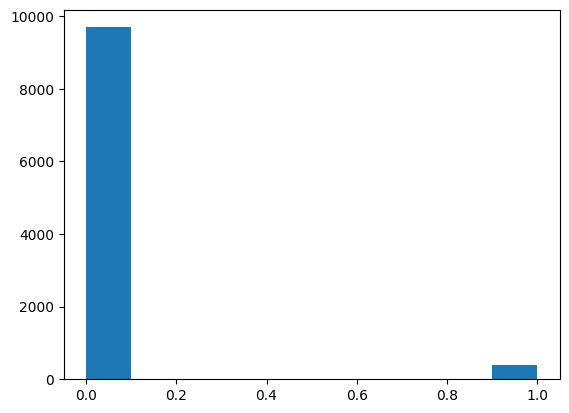

In [7]:
# insert your code here
plt.hist(df.iloc[:,-1])

**Task 4-2**:
- Generate a dataframe named `surv` that contains surviving firms, and a dataframe named `dead` that contains dead firms
- Store in variables `l_surv`and `l_dead`the number of surviving firms and dead firms, respectively

In [8]:
# insert your code here
surv, dead = df[df.iloc[:, -1]==0], df[df.iloc[:, -1]==1]
l_surv, l_dead = len(surv), len(dead)
print(l_surv, l_dead)

9693 395


**Task 5**:
- Using the `sample` function, create a `dead_train` dataframe that contains 75% of the dead firms, where those firms are ramdomly selected
- Create a `surv_train` dataframe that contains as many randomly selected surviving firms as the number of randomly selected dead firms
- Combine vertically the `dead_train` and the `surv_train` dataframes into a single dataframe names `Train`

In [9]:
np.random.seed(42) # for reproductibility of results

# insert your code here
dead_train = dead.sample(int(l_dead*.75))
surv_train = surv.sample(int(l_dead*.75))

Train = pd.concat([dead_train, surv_train], axis=0)

In [10]:
l_surv_train, l_dead_train = len(surv_train), len(dead_train)
print(l_surv_train, l_dead_train)

296 296


In [11]:
len(Train)

592

All firms not selected in the Train dataframe must now be put in the Test dataframe.

**Task 6**: 
- Create a `dead_remain` dataframe with all instances of dead firms **<u>not</u>** in the `dead_train` dataframe
- Create a `surv_remain` dataframe with all instances of surviving firms **<u>not</u>** in the `surv_train` dataframe
- Combine vertically the `dead_remain` and the `surv_remain` dataframes into a single dataframe named `Test`


In [12]:
# insert your code here
dead_remain = dead[~dead.isin(dead_train)].dropna() # observations in dead_train are reported as NaN
surv_remain = surv[~surv.isin(surv_train)].dropna()

Test = pd.concat([dead_remain, surv_remain], axis=0)

In [13]:
l_surv_remain, l_dead_remain = len(surv_remain), len(dead_remain)
print(l_surv_remain, l_dead_remain)

9397 99


The next step is to separate the labels from the features

**Task 7**: 
- Create the `Ytrain` and `Ytest` dataframes with the <u>labels</u> from the `Train` and the `Test` dataframes, respectively
- Create the `Xtrain` and `Xtest` dataframes with the <u>features</u> from the `Train` and the `Test` dataframes, respectively


In [14]:
# Extract labels
# insert your code here
Ytrain = Train.iloc[:,-1]
Ytest = Test.iloc[:,-1]

# Extract features
# insert your code here
Xtrain = Train.iloc[:,:-1] 
Xtest = Test.iloc[:,:-1]

Finally, we can normalize both the train and the test sets.

**Task 8**:
- Create the `Xtrain_norm` dataframe by applying feature scaling to the `Xtrain` dataframe
- Create the `Xtest_norm` dataframe by applying feature scaling to the `Xtest` dataframe

In [15]:
# insert your code here
Xtrain_norm, min_vals, max_vals = normalize(Xtrain)
Xtest_norm = normalize(Xtest, min_vals, max_vals)

In [16]:
Xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,...,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,0.013282,1.440260,-0.723301,3.722466,-213.398384,-1.005629,0.025442,4.032041,1.872854,-0.459846,...,2.882442,-0.008606,3.211994,1.310033,2687.924067,-0.105317,1.839165,40.811098,17.193168,7.376815
std,0.534558,19.747443,19.735366,24.979245,6104.534815,20.981582,0.539040,34.821886,1.804231,19.744712,...,22.767715,0.448191,24.884444,19.752124,27801.568825,5.115328,20.218933,980.379744,75.118744,17.539184
min,-6.815000,0.001504,-479.960000,0.002079,-146150.000000,-508.410000,-6.815000,-0.997810,0.000000,-479.910000,...,0.000180,-7.881700,0.002079,0.001504,-259740.000000,-76.982000,0.000000,-80.147000,0.000000,0.000000
25%,-0.018667,0.345823,-0.067543,0.871020,-64.328500,-0.007887,-0.018488,0.242565,1.013975,0.195213,...,0.440908,-0.054973,0.661705,0.255537,-268.292500,0.000000,0.889915,0.000000,4.685025,2.714975
50%,0.027529,0.586305,0.114150,1.257850,-18.437000,0.000000,0.035270,0.683745,1.214700,0.400245,...,0.739520,0.010124,1.003650,0.421305,444.820000,0.087228,0.966220,0.005827,7.241400,4.347150
75%,0.112798,0.793290,0.293238,2.161025,28.649250,0.014939,0.128980,1.822100,2.328850,0.628208,...,1.405500,0.103478,1.613200,0.647305,2269.950000,0.286965,1.000775,0.323578,11.382500,7.807550
max,7.372700,480.960000,0.975730,431.120000,22876.000000,0.772020,7.372700,664.010000,22.743000,0.998500,...,421.770000,0.928760,431.120000,480.960000,537580.000000,38.355000,492.000000,23853.000000,1324.500000,376.040000


In [17]:
Xtrain_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,...,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,0.481282,0.002991,0.996467,0.008630,0.863397,0.996509,0.482139,0.007564,0.082349,0.996968,...,0.006834,0.893608,0.007446,0.002721,0.329138,0.666540,0.003738,0.005054,0.012981,0.019617
std,0.037678,0.041059,0.041035,0.057941,0.036116,0.041206,0.037993,0.052363,0.079331,0.041057,...,0.053981,0.050870,0.057721,0.041068,0.034869,0.044351,0.041095,0.040963,0.056715,0.046642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.479030,0.000716,0.997831,0.002016,0.864279,0.998468,0.479043,0.001865,0.044584,0.998330,...,0.001045,0.888345,0.001530,0.000528,0.325430,0.667453,0.001809,0.003349,0.003537,0.007220
50%,0.482286,0.001216,0.998209,0.002913,0.864551,0.998484,0.482832,0.002529,0.053410,0.998756,...,0.001753,0.895733,0.002323,0.000873,0.326324,0.668209,0.001964,0.003349,0.005467,0.011560
75%,0.488296,0.001646,0.998581,0.005008,0.864829,0.998513,0.489437,0.004240,0.102399,0.999230,...,0.003332,0.906329,0.003737,0.001343,0.328613,0.669941,0.002034,0.003362,0.008594,0.020763
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
Xtest.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,...,9496.000000,9496.000000,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000
mean,0.059580,0.583189,0.130977,3.438784,-114.861777,-0.046815,0.143469,3.802624,2.910833,0.400218,...,2.586799,0.088178,2.744910,0.467164,6.174652e+03,-0.035702,13.234083,0.703249,16.855230,11.426099
std,0.687204,4.605438,4.600310,14.939694,6925.480649,4.275350,6.697446,28.988943,100.010548,4.605299,...,14.118622,6.412551,12.526885,4.602961,6.736910e+04,12.606009,653.658670,29.089834,305.222767,241.689277
min,-61.628000,0.000626,-440.740000,0.002264,-438250.000000,-398.120000,-61.628000,-1.594500,-0.000857,-440.740000,...,-5.256100,-9.679200,0.002264,0.000516,-1.805200e+06,-979.250000,-4.549700,-189.580000,-0.007521,-0.367890
25%,0.000894,0.277290,0.015974,1.039300,-49.059250,0.000000,0.002899,0.409535,1.029000,0.283410,...,0.592220,-0.038386,0.759858,0.194315,1.466975e+01,0.011969,0.871975,0.000000,4.725850,3.149050
50%,0.051782,0.483060,0.193560,1.541800,-0.939565,0.000000,0.062915,1.028300,1.295700,0.495375,...,1.015050,0.024399,1.206650,0.348455,8.793950e+02,0.129680,0.948945,0.005109,7.005200,5.273050
75%,0.143402,0.698887,0.401905,2.766825,51.780500,0.080294,0.168065,2.542125,2.262225,0.704827,...,1.896000,0.123900,2.172925,0.544880,4.181975e+03,0.312032,0.993080,0.247670,11.079250,9.097200
max,7.138400,441.740000,0.996880,782.250000,70686.000000,14.756000,649.230000,1597.400000,9742.300000,0.999370,...,782.250000,623.850000,544.560000,441.740000,3.657400e+06,147.190000,59672.000000,2517.700000,26862.000000,23454.000000


In [19]:
Xtest_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,9496.000000,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,...,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000
mean,0.484545,0.001209,0.998244,7.971612e-03,0.863980,0.998392,0.490458,0.007219,0.127988,0.998756,...,0.006133,0.904593,6.362136e-03,0.000968,0.333511,0.667143,0.026899,0.003378,0.012726,0.030385
std,0.048437,0.009576,0.009565,3.465338e-02,0.040973,0.008397,0.472060,0.043592,4.397421,0.009576,...,0.033475,0.727834,2.905675e-02,0.009570,0.084494,0.109297,1.328575,0.001215,0.230444,0.642722
min,-3.863417,-0.000002,0.081549,4.281891e-07,-1.728136,0.216602,-3.863417,-0.000897,-0.000038,0.081450,...,-0.012462,-0.204019,4.281891e-07,-0.000002,-1.938318,-7.822884,-0.009247,-0.004572,-0.000006,-0.000978
25%,0.480409,0.000573,0.998004,2.405887e-03,0.864370,0.998484,0.480550,0.002116,0.045245,0.998513,...,0.001404,0.890227,1.757705e-03,0.000401,0.325785,0.667557,0.001772,0.003349,0.003568,0.008374
50%,0.483995,0.001001,0.998374,3.571461e-03,0.864654,0.998484,0.484780,0.003047,0.056971,0.998954,...,0.002406,0.897354,2.794063e-03,0.000721,0.326869,0.668577,0.001929,0.003349,0.005289,0.014023
75%,0.490453,0.001450,0.998807,6.412969e-03,0.864966,0.998641,0.492191,0.005323,0.099469,0.999389,...,0.004495,0.908647,5.035388e-03,0.001130,0.331011,0.670158,0.002018,0.003359,0.008365,0.024192
max,0.983486,0.918455,1.000044,1.814464e+00,1.282856,1.027464,46.240405,2.403578,428.364772,1.000002,...,1.854684,71.702465,1.263130e+00,0.918455,4.912883,1.943626,121.284553,0.108546,20.280861,62.371024


## 2. Optimisation and learning

Bankruptcy probability prediction

For each instance *i*, the model has to return the estimated probability $\hat{p}^{(i)}$ that the firm will go bankrupt conditional on the corresponding vector of features $x^{(i)}$.

The prediction wil be made using the logistic function. With the logistic function, conditional probabilities are computed as follows

\begin{equation}
    \left\{
    \begin{array}{ll}
        \hat{p}\left( y^{(i)} = 1 | \omega, b, x^{(i)} \right) & = \sigma\left(\omega^{T} x^i + b\right) \\
        \hat{p}\left( y^{(i)} = 0 | \omega, b, x^{(i)} \right) & = 1 - \sigma\left(\omega^{T} x^i + b\right)
    \end{array}
    \right.
\end{equation}
where:

- $x^{(i)}$ is a column vector with 37 components (number of remaining features);
- $w$ is a column vector of $n=37$ weights (coefficients);
- $b$ is a bias term (intercept/constant);
- $\sigma$ is the logistic function, i.e. $\sigma(t) = \frac{1}{\left(1+\exp(-t)\right)}$.

### 2.1 Class prediction

The prediction rule is as follows:
\begin{equation}
    \hat{y}^{(i)} = \left\{
    \begin{array}{ll}
        0 & \mbox{ if } \hat{p}^{(i)} < 0.5 \\
        1 & \mbox{ if } \hat{p}^{(i)} \geq 0.5
    \end{array}
    \right.
\end{equation}

Replacing $\hat{p}^{(i)}$ by its expression as computed using the logistic function we get the following:
<img src="Logistic-Function.png" width=50%>

### 2.2 Cost function

Training the model aims at determining the $\omega$ and $b$ values such that the model estimates a high $\hat{p}^{(i)}$ value when $y^{(i)}=1$ and a low $\hat{p}^{(i)}$ value when $y^{(i)}=0$

This is achieved by defining a cost function $F(\omega,b)$ which, for example $i$, is computed as:
\begin{equation}
    F^{(i)}(\omega,b) = \left\{
    \begin{array}{ll}
        -log(\hat{p}^{(i)}) & \mbox{ if } y^{(i)} = 1 \\
        -log(1 - \hat{p}^{(i)}) & \mbox{ if } y^{(i)} = 0
    \end{array}
    \right.
\end{equation}
For a set of $m$ instances (or a batch of size $m$), the cost expresses:
$$ F(\omega,b) = - \frac{1}{m}\sum^{m}_{i=1} y^{(i)} \log \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right]+ (1 - y^{(i)}) \log \left[ 1 - \sigma \left( \omega^T x^{(i)} + b \right) \right]$$

We can check that the total cost increases with errors:

- if the model predicts a low $\hat{p}^{(i)}$ probability of bankruptcy for fimr $i$ whereas it goes bankrupt, i.e. when $y^{(i)} = 1$, $- y^{(i)}\log\left(\hat{p}^{(i)} \right)$ is large;
- if the model predicts a large $\hat{p}^{(i)}$ probability of bankruptcy for fimr $i$ whereas it survives, i.e. when $y^{(i)} = 0$, $- (1 - y^{(i)})\log \left(1 - \hat{p}^{(i)} \right)$ is large.

**Note:** the cost function is the opposite of the log-likelihood:

- Assuming indepedence observations, the likelihood of observing the sample is:
\begin{eqnarray*}
    L(\omega,b) & = & \prod^{m}_{i=1} Pr\left( Y = y^{(i)} | X = x^{(i)}\right) \\
    & = & \prod^{m}_{i=1} \sigma\left(\omega^T x^{(i)} + b \right)^{y^{(i)}} . \left(1 - \sigma\left(\omega^T x^{(i)} + b \right)\right)^{(1-y^{(i)})}  
\end{eqnarray*}
    
- Therefore the expression for the log-likelihood is
$$ LL(\omega,b) = \sum^{m}_{i=1} y^{(i)} \log \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] + (1 - y^{(i)}) \log \left[ 1 - \sigma \left( \omega^T x^{(i)} + b \right) \right]$$

### 2.3 Cost minimization and gradient

***Def:*** The gradient of f: $\mathbb{R}^{n} \mapsto \mathbb{R}$ is $$\nabla f (x)=\begin{bmatrix}
\frac{\partial f}{\partial x_1} \\ 
\vdots \\
\frac{\partial f}{\partial x_n} 
\end{bmatrix} \in \mathbb{R}^{n} $$
i.e., a vector that gathers the partial derivatives of f. 

#### 2.3.1 Compute gradient

##### 2.3.1.2 Numerical approach

Numerical gradient is defined as:
$$[\nabla_{j} f(x)] = \frac{\partial f }{\partial x_j}(x)= \frac{f(x+\epsilon e_j) - f(x)}{\epsilon}, \ j \in \{ 1, \dots, n \}$$ where $\epsilon$ is a small value (e.g., 10−6).  

- Computing $[\nabla_{j} f(x)]$ approximately by finite difference is $n + 1$ times as costly as evaluating f. 

##### 2.3.1.1 Closed-forme formula

Training the model amounts to finding the $\omega$ and $b$ parameters such that the cost is minimal

Unfortunately, there is no closed-form solution to compute the $\omega$ and $b$ values that minimize the cost function

However, since the cost function is convex the optimal $\omega$ and $b$ values can be found using gradient descent (see below)

Computing the partial derivatives, we get:
$$ \frac{\partial F(\omega,b)}{\partial \omega} = \frac{1}{m} \sum^{m}_{i=1} x^{(i)} \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] - y^{(i)} $$
$$ \frac{\partial F(\omega,b)}{\partial b} = \frac{1}{m} \sum^{m}_{i=1} \sigma \left(\omega^T x^{(i)} + b \right) - y^{(i)} $$

Developping the first derivative to display the partial derivatives with respect to each component $\omega_j$ of $\omega$, we get the expression of the gradient:
$$
    \nabla_{\omega} F(\omega) = \left[
    \begin{array}{c}
        \frac{\partial F(\omega,b)}{\omega_1} \\
        \frac{\partial F(\omega,b)}{\omega_2} \\
        \vdots \\
        \frac{\partial F(\omega,b)}{\omega_n}
    \end{array}
    \right] = \left[
    \begin{array}{c}
        \frac{1}{m} \sum^{m}_{i=1} x^{(i)}_1 \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] - y^{(i)} \\
        \frac{1}{m} \sum^{m}_{i=1} x^{(i)}_2 \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] - y^{(i)} \\
        \vdots \\
        \frac{1}{m} \sum^{m}_{i=1} x^{(i)}_n \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] - y^{(i)}
    \end{array}
    \right]
$$


**Task 9**: Coding Auxiliary functions
- Write function `sigmoid(t)` that returns the value of the sigmoid value at $t$, i.e.:
$$\sigma(t) = 1/(1+\exp(-t))$$

- Write the function `sgd_gradw(x, y, w, b)` that reports the value of the gradient components with respect to `w` for a single instance, i.e.:
$$x^{(i)}\left[\sigma\left(\omega^Tx^{(i)}+b\right) - y^{(i)} \right]$$

- Write the function `sgd_gradb(x, y, w, b)` that reports the value of the partial derivative of the cost function with respect to `b` for a single instance, i.e.:
$$\sigma\left(\omega^Tx^{(i)}+b\right) - y^{(i)}$$

- Write the function `cost(x, y, w, b)` that returns the costs for instance $i$, i.e.:
$$-y^{(i)} \log \sigma
\left(\omega^Tx^{(i)}+b\right) - \left(1 - y^{(i)}\right)
\log\left[1 - \sigma
\left(\omega^Tx^{(i)}+b\right) \right]$$

- Write the function `prediction(x, w, b)`that returns the predicted $\hat{y}^{(i)}$

In [20]:
def sigmo(t):
    return 1/(1+np.exp(-t))

def sgd_gradw(x, y, w, b):
    return x*(sigmo(np.dot(w,x)+b)-y)

def sgd_gradb(x, y, w, b):
    return sigmo(np.dot(w,x)+b)-y

def cost(x, y, w, b):
    return -y*np.log(sigmo(np.dot(w,x)+b)) - (1-y)*np.log(1-sigmo(np.dot(w,x)+b))

def prediction(x, w, b):
    out = sigmo(np.dot(w,x)+b)
    if out >= .5:
        return 1
    else:
        return 0

- Hard when you have a more complicated gradient to compute. How to do it ?

##### 2.3.1.2 Automatic differentiation

***Def:*** The Jacobian of f: $\mathbb{R}^{n} \mapsto \mathbb{R}^{m}$ is
$$ J_{f}(x)= \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \dots & \frac{\partial f_1}{\partial x_n} \\ 
\vdots & \ddots  & \vdots \\ 
 \frac{\partial f_m}{\partial x_1} &\dots   & \frac{\partial f_m}{\partial x_m}
\end{bmatrix}$$

$$J_{f}(x)=\begin{bmatrix}
\frac{\partial f}{\partial x_1} & \dots & \frac{\partial f}{\partial x_n} \\ 
\end{bmatrix}$$

$$J_{f}(x)= \begin{bmatrix}
\nabla f_{1} (x)^T  \\
 \vdots \\
\nabla f_{m} (x)^T 
\end{bmatrix}$$


***Def:*** Derivative of $\mathbb{R}^{n} \mapsto \mathbb{R}$ in the direction of $v \in \mathbb{R}^{n}$
$$D_{v} f(x)= \underset{h \rightarrow 0}{\mathrm{lim}} \frac{f(x+h v) - f(x)}{\epsilon}, \ j \in \{ 1, \dots, n \}  $$
Interpretation: rate of change of $f$ in the direction of $v$, when moving away from $x$.
Finite difference: $$D_{v} f(x) \approx \frac{f(x+h v) - f(x)}{h}$$

Only **2** calls to f are needed, i.e., independent of n.


**Def of Jacobian vector product ("JVP"):** 

Right-multiply the Jacobian with a vector $v\in \mathbb{R}^n$ 
$$J_{f}(x)v=\begin{bmatrix}
\nabla f_{1} (x)^T  \\
 \vdots \\
\nabla f_{m} (x)^T 
\end{bmatrix} v$$
$$J_{f}(x)v=\begin{bmatrix}
\nabla f_{1} (x) . v  \\
 \vdots \\
\nabla f_{m} (x) . v 
\end{bmatrix}$$
$$J_{f}(x)v=  \underset{h \rightarrow 0}{\mathrm{lim}} \frac{f(x+h v) - f(x)}{h}$$
- Computing the JVP approximately by (central) finite difference requires only 2 calls to $f$.

**Def of Vector Jacobian Product ("VJP")** 

Left-multiply the Jacobian with a vector $u\in \mathbb{R}^m$ 
$$u^{T} J_{f}(x)= u^{T} \begin{bmatrix}
\frac{\partial f}{\partial x_1} & \dots & \frac{\partial f}{\partial x_n}
\end{bmatrix} v$$
Finite difference
$$\frac{\partial f }{\partial x_j}(x)= \frac{f(x+\epsilon e_j) - f(x)}{\epsilon}$$
- Computing the VJP approximately by finite difference requires $n + 1$ calls (2$n$ calls) to f.

<img src="Chain_rules_1.png" width=50% align="center">

$$f=f_4(f_3(f_2(f_1(x)))))$$
$$f=f_4 \circ \dots \circ f_1$$ 
$$x_2=f_1(x, w) = w \times x$$ 
$$x_3= f_2(x_2,b)= x_2 +b$$
$$x_4= f_3(x_3,\otimes)= \sigma(x_3)$$
$$o= F(x_4,y)$$

<img src="composition_function.png" width=50%>

***Forward differentiation***

<img src="Forward_diff.png" width=50%>

<img src="Forward_diff_algo.png" width=50%>

- Most case inefficient in ML

***Backward differentiation (i.e Backpropagation)***

<img src="Backward_diff.png" width=50%>

<img src="Backward_diff_algo.png" width=50%>

***Let's code in our case !***

In [21]:
def num_jvp(f, x, v, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array.
    v: an array (same shape as x).

  Returns:
    numerical_jvp
  """
  if not np.array_equal(x.shape, v.shape):
    raise ValueError("x and v should have the same shape.")

  return (f(x + eps * v) - f(x - eps * v)) / (2 * eps)

def num_jacobian(f, x, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

  Returns:
    numerical_jacobian
  """
  def e(i):
    ret = np.zeros_like(x)
    ret[i] = 1
    return ret

  def E(i, j):
    ret = np.zeros_like(x)
    ret[i, j] = 1
    return ret

  if len(x.shape) == 1:
    return np.array([num_jvp(f, x, e(i), eps=eps) for i in range(len(x))]).T
  elif len(x.shape) == 2:
    return np.array([[num_jvp(f, x, E(i, j), eps=eps) \
                     for i in range(x.shape[0])] \
                     for j in range(x.shape[1])]).T
  else:
    raise NotImplementedError

def num_vjp(f, x, u, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

  Returns:
    numerical_vjp
  """
  J = num_jacobian(f, x, eps=eps)
  if len(J.shape) == 2:
    return J.T.dot(u)
  elif len(J.shape) == 3:
    shape = J.shape[1:]
    J = J.reshape(J.shape[0], -1)
    return u.dot(J).reshape(shape)
  else:
    raise NotImplementedError

##### Vector Jacobian products (VJPs) for basic primitives



In [22]:
def dot(x, W):
  return np.dot(W, x)

def dot_make_vjp(x, W):
  def vjp(u):
    return W.T.dot(u), np.outer(u, x)
  return vjp

dot.make_vjp = dot_make_vjp

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def tanh(x):
  #On ne leurs donne pas cela 
  return np.tanh(x)
    
def squared_loss(y_pred, y):
  # The code requires every output to be an array.
  return np.array([0.5 * np.sum((y - y_pred) ** 2)])

def squared_loss_make_vjp(y_pred, y):
  diff = y_pred - y

  def vjp(u):
    return diff * u, -diff * u

  return vjp

squared_loss.make_vjp = squared_loss_make_vjp

# Cross-entropy loss
def cross_entropy_loss(y_pred, y):
    cross_entropy = -y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)
    return np.array([cross_entropy])

def add(a, b):
  return a + b

def add_make_vjp(a, b):
  gprime = np.ones(len(a))


  def vjp(u):
    return u * gprime, u * gprime

  return vjp

add.make_vjp = add_make_vjp

def mul(a, b):
  return a * b

def mul_make_vjp(a, b):
  gprime_a = b
  gprime_b = a

  def vjp(u):
    return u * gprime_a, u * gprime_b

  return vjp

mul.make_vjp = mul_make_vjp

def exp(x):
  return np.exp(x)

def exp_make_vjp(x):
  gprime = exp(x)

  def vjp(u):
    return u * gprime,

  return vjp

exp.make_vjp = exp_make_vjp

def sqrt(x):
  return np.sqrt(x)

def sqrt_make_vjp(x):
  gprime = 1. / (2 * sqrt(x))

  def vjp(u):
    return u * gprime,

  return vjp

sqrt.make_vjp = sqrt_make_vjp

**Task 10** 

Look at the "exp", "sqrt" and "squared_loss" examples above and define the primitive and its associated VJP for the sigmoid function: `sigmoid(x) = 1/(1+ np.exp(-x))`, for the hyperbolic tangent function: `tanh(x) = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))` and cross entropy loss: `-y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)`. Check the correctness of your implementation using the `num_vjp` utility function.

In [23]:
def sigmoid_make_vjp(x):
  #gprime= np.exp(-x)/ ((1+ np.exp(-x))**2)

  gprime=sigmoid(x)* (1-sigmoid(x))

  def vjp(u):
    return u * gprime,

  return vjp

sigmoid.make_vjp = sigmoid_make_vjp

def cross_entropy_loss_make_vjp(y_pred, y):
    gprime_y = np.log(1 - y_pred) - np.log(y_pred)
    gprime_y_pred= (1-y)/(1-y_pred) - (y)/(y_pred)

    def vjp(u):
      return u*gprime_y_pred, u* gprime_y

    return vjp

cross_entropy_loss.make_vjp = cross_entropy_loss_make_vjp

def tanh_make_vjp(x):
 
  gprime=(1-tanh(x)**2)

  def vjp(u):
    return u * gprime,

  return vjp

tanh.make_vjp = tanh_make_vjp

In [24]:
rng = np.random.RandomState(0)
x_test_toy = rng.randn(5)
u_test_toy = rng.randn(5)

In [25]:
def sigmoid_make_vjp_test(x,u):
  r = [sigmoid_make_vjp(x[i])(u[i]) for i in range(len(x))]
  return r

print('Our implementation:\n')
print(sigmoid_make_vjp_test(x_test_toy,u_test_toy))

print('\nCheck with VJP:\n')
print(num_vjp(sigmoid, x_test_toy, u_test_toy))

Our implementation:

[(-0.1220470202913649,), (0.22826186750045688,), (-0.030049789465322333,), (-0.00896924374617215,), (0.047594742900286875,)]

Check with VJP:

[-0.12204702  0.22826187 -0.03004979 -0.00896924  0.04759474]


In [26]:
def tanh_make_vjp_test(x,u):
  r = [tanh_make_vjp(x[i])(u[i]) for i in range(len(x))]
  return r

print('Our implementation:\n')
print(tanh_make_vjp_test(x_test_toy,u_test_toy))

print('\nCheck with VJP:\n')
print(num_vjp(tanh, x_test_toy, u_test_toy))

Our implementation:

[(-0.10831950192035003,), (0.8128353740579084,), (-0.0656458992394884,), (-0.004567016431177733,), (0.037397891282206844,)]

Check with VJP:

[-0.1083195   0.81283537 -0.0656459  -0.00456702  0.03739789]


In [27]:
# simulate relevant values
y_pred_test_toy = rng.rand(5)
y_test_toy = rng.rand(5)
u_test_toy = rng.randn(5)

print('# set value for y_pred, get derivative over y:\n')
y_pred_ref_value = y_pred_test_toy[0]
def f(x, eps = 1e-3):
  return cross_entropy_loss(y_pred = y_pred_ref_value, y = x)
print('> our implementation:\n')
print([cross_entropy_loss_make_vjp(y_pred = y_pred_ref_value, y = y_test_toy[i])(u_test_toy[i])[1] for i in range(len(y_test_toy))])
print('\n> check with VJP:\n')
print(num_vjp(f = f, x = y_test_toy, u = u_test_toy))

print('\n\n# set value for y, get derivative over y_pred:\n')
y_ref_value = y_test_toy[0]
def f(x, eps = 1e-3):
  return cross_entropy_loss(y_pred = x, y = y_ref_value)
print('Our implementation:\n')
print([cross_entropy_loss_make_vjp(y_pred = y_pred_test_toy[i], y = y_ref_value)(u_test_toy[i])[0] for i in range(len(y_test_toy))])
print('\nCheck with VJP:\n')
print(num_vjp(f = f, x = y_pred_test_toy, u = u_test_toy))


# set value for y_pred, get derivative over y:

> our implementation:

[-1.9951259882042933, 0.2739591170827161, -0.41805652649363706, 1.1405210316573902, 3.4091477624585944]

> check with VJP:

[[-1.99512599  0.27395912 -0.41805653  1.14052103  3.40914776]]


# set value for y, get derivative over y_pred:

Our implementation:

[6.384136315744669, -0.3637422478589341, 0.6136001703421502, -10.398683938095902, 0.6226082908779592]

Check with VJP:

[[  6.38413632  -0.36374225   0.61360017 -10.39868394   0.62260829]]


***Reverse differentiation of feedforward networks***

We represent a feedforward network using a list of functions and a list of parameters. Let us create a small utility function for creating such a network.

In [28]:
def create_feed_forward(n, y, seed=0):
  rng = np.random.RandomState(seed)

  funcs = [
    dot,
    add,
    sigmoid,
    cross_entropy_loss,
  ]

  params = [
        rng.randn(1, n), # w
        rng.randn(1), # b
        None,   
        y
  ]

  return funcs, params

Next, let us create a small utility function for correctly calling each function, depending on whether it has 1 or 2 arguments.

In [29]:
def call_func(x, func, param):
  """Make sure the function is called with the correct number of arguments."""

  if param is None:
    # Unary function
    return func(x)
  else:
    # Binary function
    return func(x, param)

***Task 11***  

Implement the following function for evaluating the feedforward network. Check that the returned value is correct.

In [60]:
def evaluate_chain(x, funcs, params, return_all=False):
  """
  Evaluate a chain of functions.

  Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.
    return_all: whether to return all intermediate values or only the last one.

  Returns:
    value (return_all == False) or values (return_all=True)
  """
  if len(funcs) != len(params):
    raise ValueError("len(funcs) and len(params) should be equal.")

  xs = [x]

  for k in range(len(funcs)):
    xs.append(call_func(xs[k], funcs[k], params[k]))

  if return_all:
    return xs
  else:
    return xs[-1]


In [61]:
x_toy = rng.randn(2)
y_toy = 0.69

funcs, params = create_feed_forward(n=len(x_toy), y=y_toy, seed=42)
w_toy,b_toy,_,y_toy = params

value1=evaluate_chain(x_toy, funcs, params,True)
value1

[array([-1.32818605,  0.19686124]),
 array([-0.68694769]),
 array([-0.03925915]),
 array([0.49018647]),
 array([[0.70079907]])]

In [62]:
# Make sure that `evaluate_chain(x, funcs, params)` returns the same value as
# a manual implementaton:
print(x_toy)
x1 = dot(x_toy, w_toy)
print(x1)
x2 = add(x1,b_toy)
print(x2)
x3=sigmoid(x2)
print(x3)
value = cross_entropy_loss(x3, y_toy)
value


[-1.32818605  0.19686124]
[-0.68694769]
[-0.03925915]
[0.49018647]


array([[0.70079907]])

**Task 12**

Reusing the previous function with `return_all=True`, implement the following function that returns both the network value and the Jacobian w.r.t. `x`. Check correctness of the Jacobian using `num_jacobian`.

In [63]:
def call_vjp(x, func, param, u):
  """Make sure the vjp is called with the correct number of arguments."""
  if param is None:
    vjp = func.make_vjp(x)
    vjp_x, = vjp(u)
    vjp_param = None
  else:
    vjp = func.make_vjp(x, param)
    vjp_x, vjp_param = vjp(u)
  return vjp_x, vjp_param

In [64]:
def reverse_diff_chain(x, funcs, params):
  """
  Reverse-mode differentiation of a chain of computations.

  Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.

  Returns:
    value, Jacobian w.r.t. x
  """
  # Evaluate the feedforward model and store intermediate computations,
  # as they will be needed during the backward pass.
  xs = evaluate_chain(x, funcs, params, return_all=True)
  m = xs[-1].shape[0]  # Output size
  K = len(funcs)  # Number of functions.

  # We need a list as the shape of U can change.
  U = list(np.eye(m))

  for k in reversed(range(K)):

    for i in range(m):
      vjp_x, vjp_param = call_vjp(xs[k], funcs[k], params[k], U[i])
      U[i] = vjp_x

  return xs[-1], np.array(U)

In [65]:
value, jac = reverse_diff_chain(x_toy, funcs, params)
print(jac)
print(value)

[[-0.09925021  0.02762708]]
[[0.70079907]]


In [66]:
# Check correctness of Jacobian using `num_jacobian`.
def f(x):
  return evaluate_chain(x, funcs, params)
# # num_jacobian only accepts functions of one argument.
num_jac = num_jacobian(f, x_toy)
value_test, jac_test = reverse_diff_chain(x_toy, funcs, params)
print(num_jac)
print(jac_test)
print(value_test)

[[[-0.09925021  0.02762708]]]
[[-0.09925021  0.02762708]]
[[0.70079907]]


**Task 13**

Modify the above function to also return the Jacobians w.r.t. W1, W3, W5. Check correctness using `num_jacobian`.

In [67]:
def reverse_diff_chain_2(x, funcs, params):
  """
  Reverse-mode differentiation of a chain of computations.

  Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.

  Returns:
    value, Jacobian w.r.t. x, Jacobians w.r.t. params.
  """
  # Evaluate the feedforward model and store intermediate computations,
  # as they will be needed during the backward pass.
  xs = evaluate_chain(x, funcs, params, return_all=True)

  m = xs[-1].shape[0]  # Output size
  K = len(funcs)  # Number of functions.

  # We need a list as the shape of U can change.
  U = list(np.eye(m))

  # List that will contain the Jacobian of each function w.r.t. parameters.
  J = [None] * K

  for k in reversed(range(K)):
    jac = []

    for i in range(m):
      vjp_x, vjp_param = call_vjp(xs[k], funcs[k], params[k], U[i])
      jac.append(vjp_param)
      U[i] = vjp_x

    J[k] = np.array(jac)

  return xs[-1], np.array(U), J

In [68]:
value, jac, W = reverse_diff_chain_2(x_toy, funcs, params)
print(x_toy)
print(jac)
print(W)
print(value)

[-1.32818605  0.19686124]
[[-0.09925021  0.02762708]]
[array([[[ 0.26538954, -0.03933554]]]), array([[-0.19981353]]), array([None], dtype=object), array([[0.03925915]])]
[[0.70079907]]


**Task 15:**

Validate preceding results with JAX framework

In [69]:
import jax.numpy as jnp
from jax import grad

def jnp_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Computes our network's output
def net(params, x):
    w, b = params
    return jnp_sigmoid(jnp.dot(w, x) + b)

# Cross-entropy loss
def loss(params, x, y):
    out = net(params, x)
    cross_entropy = -y * jnp.log(out) - (1 - y)*jnp.log(1 - out)
    return cross_entropy[0]

# compute loss gradient
loss_grad = grad(loss)

In [40]:
rng = np.random.RandomState(42)
# random initialization of w and b
w_comp = rng.randn(1, Xtrain_norm.shape[1])
b_comp = rng.randn(1)

Xtrain_rand = Xtrain_norm.sample(frac=1)
# Reorder Ytrain in the same order as Xtrain_rand
Ytrain_rand = Ytrain.reindex(Xtrain_rand.index)
x_comp = Xtrain_rand.iloc[0,:]
y_comp = Ytrain_rand.iloc[0]


In [41]:
#######Closed_formulas
grad_w_cf = sgd_gradw(x_comp, y_comp, w_comp, b_comp)
grad_b_cf = sgd_gradb(x_comp, y_comp, w_comp, b_comp)

print(np.array(grad_w_cf))
print(np.array(grad_b_cf))



[6.07538697e-02 5.56342348e-05 1.23467230e-01 9.43613134e-04
 1.06921326e-01 1.23491621e-01 6.11095178e-02 7.07033642e-04
 6.20803034e-03 1.23512209e-01 5.83139740e-02 4.76627384e-03
 6.11095178e-02 1.30546533e-02 3.15705133e-03 8.52393673e-04
 6.11095178e-02 1.09731053e-01 1.23517394e-01 3.67440370e-03
 8.15305352e-02 7.46107126e-03 2.83024740e-03 1.15493354e-01
 8.73591942e-03 1.23521853e-01 6.59492315e-04 6.10869407e-04
 1.12382103e-01 7.81098232e-04 4.59937497e-05 4.23582165e-02
 8.27820201e-02 2.19973475e-04 4.14265857e-04 5.55202525e-04
 2.80302350e-03]
[0.12361166]


In [42]:
def create_feed_forward_2(y,w,b):
  

  funcs = [
    dot,
    add,
    sigmoid,
    cross_entropy_loss,
  ]

  params = [
        w, # w
        b, # b
        None,   
        y
  ]

  return funcs, params

funcs, params = create_feed_forward_2(y=y_comp,w=w_comp,b=b_comp)
w_comp,b_comp,_,y_comp = params
value, jac, W = reverse_diff_chain_2(np.array(x_comp), funcs, params)
print(W)



[array([[[6.07538697e-02, 5.56342348e-05, 1.23467230e-01, 9.43613134e-04,
         1.06921326e-01, 1.23491621e-01, 6.11095178e-02, 7.07033642e-04,
         6.20803034e-03, 1.23512209e-01, 5.83139740e-02, 4.76627384e-03,
         6.11095178e-02, 1.30546533e-02, 3.15705133e-03, 8.52393673e-04,
         6.11095178e-02, 1.09731053e-01, 1.23517394e-01, 3.67440370e-03,
         8.15305352e-02, 7.46107126e-03, 2.83024740e-03, 1.15493354e-01,
         8.73591942e-03, 1.23521853e-01, 6.59492315e-04, 6.10869407e-04,
         1.12382103e-01, 7.81098232e-04, 4.59937497e-05, 4.23582165e-02,
         8.27820201e-02, 2.19973475e-04, 4.14265857e-04, 5.55202525e-04,
         2.80302350e-03]]]), array([[0.12361166]]), array([None], dtype=object), array([[1.95866446]])]


In [43]:
####Numeric using JAX
grad_num=loss_grad([jnp.array(w_comp),jnp.array(b_comp)],jnp.array(x_comp),jnp.array(y_comp))
print(grad_num)

[DeviceArray([[6.07538894e-02, 5.56342566e-05, 1.23467281e-01,
              9.43613530e-04, 1.06921367e-01, 1.23491667e-01,
              6.11095391e-02, 7.07033963e-04, 6.20803284e-03,
              1.23512253e-01, 5.83139956e-02, 4.76627564e-03,
              6.11095391e-02, 1.30546587e-02, 3.15705244e-03,
              8.52393976e-04, 6.11095391e-02, 1.09731093e-01,
              1.23517439e-01, 3.67440516e-03, 8.15305710e-02,
              7.46107381e-03, 2.83024856e-03, 1.15493402e-01,
              8.73592310e-03, 1.23521894e-01, 6.59492565e-04,
              6.10869611e-04, 1.12382151e-01, 7.81098555e-04,
              4.59937692e-05, 4.23582308e-02, 8.27820525e-02,
              2.19973561e-04, 4.14266018e-04, 5.55202714e-04,
              2.80302460e-03]], dtype=float32), DeviceArray([0.1236117], dtype=float32)]


#### 2.3.2 Algorithm to find the minimal cost : Gradient Descent

<img src="Gradient_Descent.png" width=50%>

##### 2.3.2.1 Batch Gradient Descent

In batch gradient descent, parameters are updated using the full training set at every step

Gradient descent algorithm:
1. Initialize $\omega$ components and $b$ with random values
2. Iterate until convergence to minimum cost (or other stopping criterion):
    1. For all $j \in [1,n]: \omega_j := w_j - \eta \frac{\partial}{\partial \omega_j} J(\omega,b)$
    2. $b := b -\eta \frac{\partial}{\partial b} J(\omega,b)$
where $\eta$ is call the learning rate. It determines the size of the downhill step

As $\eta$ is at the discretion of the modeler, it is a hyperparameter of the model:
- If it is too small, convergence will be slow and potentiall will not be reached;
- If it is too high, the parameter values may bounce around their 'true' value and potentially the algorithm may diverge.

<img src="Batch_Gradient_Descent.png" width=70%>

The number of iterations is another parameter that is at the discretion of the modeler
- If the number of iterations is too low, the model will not have enough steps to reach the minimul cost;
- If it is too high, there will ne unneccessary steps when the gradient value is near 0.

##### 2.3.2.2 Stochastic Gradient Descent (SGD)

SGD aims at overcoming batch gradient descent drawbacks.

Instead of updating parameters using the whole training set, SGD performs the update using a single randomly picked instance (hence its stochastic feature).

Pros:
The algorithm is extremely fast as very little data is used at every step
- It is therefore possible to train the model on very large datasets;
- Since the instances are randomly selected, SGD avoids the risk of being stuck on a local optimum and there is a better chance to find a global minimum.

Cons:
- Due to its random feature, the algorithm cannot settle at the minimum although it can get close to it;
- This issue can be avoided by adjusting the learning rate (learning schedule): large in the first steps (to avoid local optima) and smaller later on to settle at the global minimum.

<img src="Stochastic_Gradient_Descent.png" width=60%>

**SGD algorithm:**
1. Initialize 𝑤 components and 𝑏 with random values
2. Iterate over a certain number of epochs:
    1. Randomly shuffle the dataset
    2. For all $i \in [1, m]$
        1. For all $j \in [1, n]: \omega_j := \omega_j - \eta \frac{\partial}{\partial \omega_j} J^{(i)} (\omega,b)$
        2. $b := b - \eta \frac{\partial}{\partial b} J^{(i)} (\omega,b)$
        
The term epoch refers to one cycle through the full training set, i.e. after one epoch all instances in the set have been used to update the parameters

The number of epochs is another hyperparameter of the model.

In [44]:
eta = 0.01
loss_list=[]
np.random.seed(42)
# random initialization of w and b
w = np.random.uniform(low=-1, high=1, size=Xtrain_norm.shape[1]) 
b = np.random.uniform(low=-1, high=1, size=1)

for epoch in range(100):
    # Shuffle randomly Xtrain_norm
    Xtrain_rand = Xtrain_norm.sample(frac=1)
    # Reorder Ytrain in the same order as Xtrain_rand
    Ytrain_rand = Ytrain.reindex(Xtrain_rand.index)
    for i in range(Xtrain_rand.shape[0]):
        x = Xtrain_rand.iloc[i,:]
        y = Ytrain_rand.iloc[i]
        grad_w = sgd_gradw(x, y, w, b)
        grad_b = sgd_gradb(x, y, w, b)
        w -=eta * grad_w
        b -=eta * grad_b
    loss = 0
    for i in range(Xtrain_rand.shape[0]):
        x = Xtrain_rand.iloc[i,:]
        y = Ytrain_rand.iloc[i]
        loss += cost(x, y, w, b)
    loss = loss / Xtrain_rand.shape[0]
    loss_list.append(loss)
    if epoch % 10 == 0:
        print("loss epoch", epoch, ":", loss)
print("loss epoch", epoch, ":", loss)
print("\nfinished\n")

loss epoch 0 : [0.6947354]
loss epoch 10 : [0.6913584]
loss epoch 20 : [0.68982568]
loss epoch 30 : [0.72791149]
loss epoch 40 : [0.70077783]
loss epoch 50 : [0.68721113]
loss epoch 60 : [0.68921409]
loss epoch 70 : [0.68547134]
loss epoch 80 : [0.68327611]
loss epoch 90 : [0.68854094]
loss epoch 99 : [0.68636452]

finished



Evolution of loss (cost) through epochs

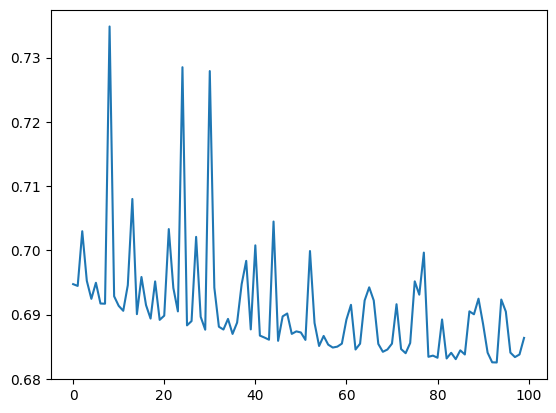

In [45]:
epoch = np.arange(len(loss_list))
plt.plot(epoch, loss_list)

**Accuracy**

Accuracy (on the train set) corresponds to the ratio of correct predictions divided by the number of instances.

**Task 10**: Code the computation of the accuracy on the train set.

In [46]:
count_ok = 0
for i in range(Xtrain_norm.shape[0]):
        x = Xtrain_norm.iloc[i,:]
        y = Ytrain.iloc[i]
        if prediction(x, w, b) == y:
            count_ok += 1
print("accuracy:{:.2f}%".format(100 * count_ok/Xtrain_norm.shape[0]))

accuracy:52.36%


Weights ($\omega$)

<AxesSubplot:>

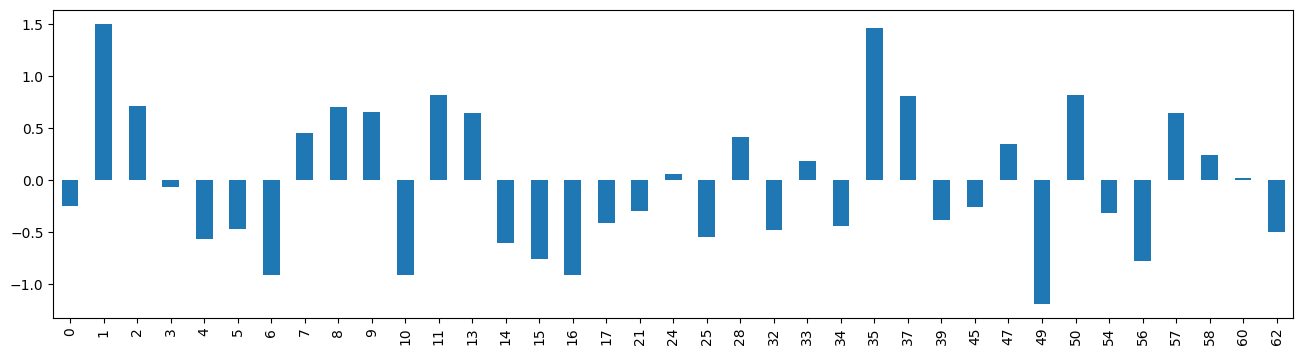

In [47]:
plt.figure(figsize=(16,4))
w.plot.bar()

##### 2.3.2.3 Mini-batch gradient descent

A limitation of the SGD is its relative slownes. This is due to the fact that parameters are updated every instance.

Mini-batch gradient overcomes this issue by computing the gradients using small random sets of instances called mini-batches.

Mini-batch is faster than SGD because it allows to take advantage of optimized matrix operations, all the more so as the computations are performed using GPUs

Another advantage of mini-batch is that the way the algorithm progressess in parameter space is less erratic which allows to get closer to a minimum than SGD.

However, the algorithm is more prone to get stuck to a local minimum.

The algorithm is almost the same as with SGD, the exception being that gradient computations are performed on a set of instances instead of a single one.

**Mini-batch algorithm:**
1. Initialize 𝑤 components and 𝑏 with random values
2. Iterate over a certain number of epochs:
    1. Randomly shuffle the dataset
    2. For all $B \in [1, l]$
        1. $\omega := \omega - \eta \frac{\partial}{\partial \omega} J^{B} (\omega,b)$
        2. $b := b - \eta \frac{\partial}{\partial b} J^{B} (\omega,b)$
        
The size of the mini-batch also is a hyperparameter of the model.

Computing of gradient with respect to $\omega$:
- Remember that $$ \frac{\partial J(\omega,b)}{\partial \omega} = \frac{1}{m} \sum^{m}_{i=1} x^{(i)} \left[ \sigma \left(\omega^T x^{(i)} + b \right)- y^{(i)} \right] $$
$$ \frac{\partial J(\omega,b)}{\partial b} = \frac{1}{m} \sum^{m}_{i=1} \sigma \left(\omega^T x^{(i)} + b \right) - y^{(i)} $$
- Let introduce the following notations:
$$
    X = \left[
    \begin{array}{ccc}
        x^{(i)}_1 & \cdots & x^{(i)}_{37} \\
        \vdots & \ddots& \vdots \\
        x^{(i+k-1)}_1 & \cdots & x^{(i)}_{37}
    \end{array}
    \right] \mbox{ and } Y = \left[
    \begin{array}{c}
        y^{(i)}_1 \\
        \vdots \\
        y^{(i+k-1)}_1
    \end{array}
    \right]
$$
- With the above notations, the expression of the partial derivatives are given by:
\begin{eqnarray*}
    \frac{\partial J(\omega,b)}{\partial \omega} & = & \frac{1}{m} \left[ \left(\sigma (X \omega + b) - Y \right)^T X \right] \\
    \frac{\partial J(\omega,b)}{\partial b} & = & \frac{1}{m} \left[ \sigma (X \omega + b) - Y \right]
\end{eqnarray*}

In [48]:
def sgdb_gradw(X, Y, w, b):
    m = X.shape[0]
    return np.dot((sigmo(np.dot(X,w)+b)-Y).T,X)/m
def sgdb_gradb(X, Y, w, b):
    return np.mean(sigmo(np.dot(X,w)+b)-Y)
# Matrix operations to get the cost directly, where X is the whole set of features on the training set and Y is the whole set of labels
def costb(X, Y, w, b):
    return np.dot(Y, np.log(sigmo(np.dot(X,w)+b)))+np.dot((1-Y), np.log(1-sigmo(np.dot(X,w)+b)))

In [49]:
eta = 0.01
loss_list=[]
np.random.seed(42)
w2 = np.random.uniform(low=-1, high=1, size=Xtrain_norm.shape[1])
b2 = np.random.uniform(low=-1, high=1, size=1)
batch_size = 5
n_iter = Xtrain_norm.shape[0]//batch_size + 1
   
for epoch in range(100):
    Xtrain_rand = Xtrain_norm.sample(frac=1)                
    Ytrain_rand = Ytrain.reindex(Xtrain_rand.index)
    for i in range(n_iter):
        # you don't have to check whether the last batch is fine
        # since you'll automatically pick the remaining elements in NumPy array
        
        X = Xtrain_rand[i*batch_size:(i+1)*batch_size]                          
        Y = Ytrain_rand[i*batch_size:(i+1)*batch_size]
        
        grad_w2 = sgdb_gradw(X, Y, w2, b2)
        grad_b2 = sgdb_gradb(X, Y, w2, b2)
        
        w2 -= eta*grad_w2
        b2 -= eta*grad_b2
        
    loss = -costb(Xtrain_rand, Ytrain_rand, w2, b2) / Xtrain_rand.shape[0]
    loss_list.append(loss)
    if epoch % 10 == 0:
        print("loss epoch", epoch, ":", loss)
print("loss epoch", epoch, ":", loss)
print("\nfinished\n")

loss epoch 0 : 0.6991682336104084
loss epoch 10 : 0.6931171296813377
loss epoch 20 : 0.6927286409522013
loss epoch 30 : 0.6934948958852782
loss epoch 40 : 0.6930409741803967
loss epoch 50 : 0.6912529314675847
loss epoch 60 : 0.6916131807053439
loss epoch 70 : 0.6901205733005545
loss epoch 80 : 0.6899542865744632
loss epoch 90 : 0.6898484537177701
loss epoch 99 : 0.690028003367336

finished



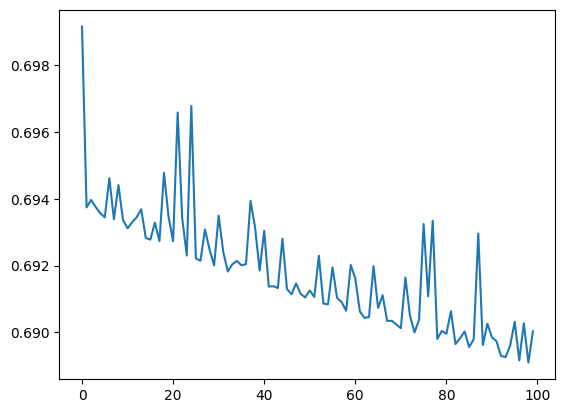

In [50]:
epoch = np.arange(len(loss_list))
plt.plot(epoch, loss_list)

In [51]:
# vectorized version of prediction accuracy
def accuracy(X, Y, w, b):
    pred = (sigmo(np.dot(X, w)+b)>=0.5)
    check = (pred==Y)
    return check.sum()/len(pred)

In [52]:
print("accuracy: {:.2f}%".format(100 * accuracy(Xtrain_norm, Ytrain, w2, b2)))

accuracy: 52.70%


## 3. How good is our model?

### 3.1 SGD

**Task 11 -1**: Compute accuracy on the test with SGD parameter estimates



In [53]:
# insert your code here
print("accuracy:{:.2f}%".format(100 * accuracy(Xtest_norm, Ytest, w, b)))

accuracy:93.24%


### 3.2 Mini-batch

**Task 11-2**: Compute accuracy on the test with Mini-batch parameter estimates


In [54]:
# insert your code here
print("accuracy:{:.2f}%".format(100 *accuracy(Xtest_norm, Ytest, w2, b2)))

accuracy:93.38%


## 4. Save train and test non-normalized datasets

In [55]:
trainset = pd.concat([Xtrain, Ytrain], axis = 1)
testset = pd.concat([Xtest, Ytest], axis = 1)
trainset.to_csv(path + "trainset_2.csv", header=True, index=False)
testset.to_csv(path + "testset_2.csv", header=True, index=False)

NameError: name 'path' is not defined